# Continuous Control

---

This is a part of Udacity project in the course of Deep Reinforcement Learning Nanodegree Program. The original solution from ddpg_pendulum of https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum was used to solve this project. 

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

### 2. Environment

This project is to solve the Reacher environment using DDPG (Deep Deterministic Policy Gradient). In Reacher environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.
The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.
The environment contains 20 identical agents, each with its own copy of the environment. The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30.

### 3. DDPG for Continuous Control Environment

Before processing the following lines, it should make sure that the Step 1 line above is run aforehand. The environment definition (env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64' , no_graphics=True) was used for the solution on the Udacity workspace. If you want to see if it is run in your local machine, the following line env = UnityEnvironment(file_name='Reacher.app') shall be used. Reacher.app can be downloaded from https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher.app.zip for Mac OS X, https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip for Linux, https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Windows_x86_64.zip for Windows. 

In [2]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from config import Config
from network import Actor, Critic
from memory import ReplayBuffer
from noise import OUNoise

import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [3]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64' , no_graphics=True)
#env = UnityEnvironment(file_name='Reacher.app')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
state_size

33

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10, n_agents = num_agents)

Episode 100	Average Score: 23.95	Score: 23.95
Episode 117	Average Score: 30.15	Score: 25.82
Environment solved in 117 episodes!	Average Score: 30.15


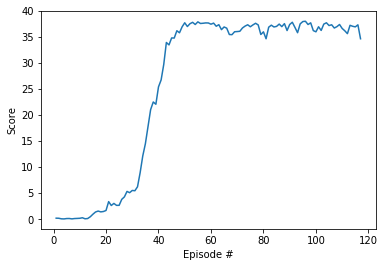

In [7]:
def ddpg(n_episodes=1000, max_t=700):
    scores_deque = deque(maxlen=100)
    all_scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(len(env_info.agents))
        
        #for t in range(max_t):
        while True: 
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            
            if np.any( dones ):                                          # exit loop if episode finished        
                break  
        
        avg_score = np.mean(scores)
        scores_deque.append(avg_score)
        all_scores.append(avg_score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(all_scores)), end="")
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break  

    return all_scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()